In [4]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [6]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB.Polypeptide import three_to_one
def get_inside_or_not_table(pdb_file):
    parser = PDBParser(PERMISSIVE=1,QUIET=True)
    try:
        structure = parser.get_structure('X', pdb_file)
    except:
        return [0]
    inside_or_not_table = []
    for res in structure.get_residues():
        if res.get_id()[0] != " ":
            continue# skip
        try:
            res["CA"].get_vector()
        except:
            print(pdb_file, res.get_id())
            return [0]
        inside_or_not_table.append(int(abs(res["CA"].get_vector()[-1]) < 15))
    return inside_or_not_table
def extractTransmembrane(toLocation, location):
    x = PDBParser().get_structure("x", location)
    class Transmembrane(Select):
        def accept_residue(self, residue):
            if abs(residue["CA"].get_vector()[-1]) < 15:
                return 1
            else:
                return 0

    io = PDBIO()
    io.set_structure(x)
    io.save(toLocation, Transmembrane())

def getSeqFromPDB(location, considerGap=True):
    x = PDBParser().get_structure("x", location)
    seq = ""
    resseqs = []
    preResId = 0
    for res in x.get_residues():
        resId = res.get_id()[1]
        if considerGap and resId != preResId + 1:
            seq += " "
            resseqs.append(-1)
        seq += three_to_one(res.get_resname())
        resseqs.append(res.get_id()[1])
        preResId = resId
    return seq,resseqs

def do(cmd, get=False, show=True):
    if get:
        out = subprocess.Popen(cmd,stdout=subprocess.PIPE,shell=True).communicate()[0].decode()
        if show:
            print(out, end="")
        return out
    else:
        return subprocess.Popen(cmd, shell=True).wait()

In [7]:
# l = "/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane/database/dompdb/3b60"
# input_pdb_filename = l
# structure = parse_pdb(input_pdb_filename)
# res_list = get_res_list(structure)

In [24]:
def get_relative_k_data_rotation(gamma, decoy, decoyQ, native, include_mem_burial=0, k_mem_burial=1):
    # gamma = 1
    rotation_all = np.arange(0, 180, 30)
    z_shift_all = np.arange(-20, 20, 4)
    rotation_axis=Vector(1,0,0)
    z_m = []
    rad_list = []
    for z_shift in z_shift_all:
        for degree in rotation_all:
            z_m.append(z_shift)
            rad_list.append(degree)
    if include_mem_burial == 1:
        # a[1] is mem contact energy
        # a[2] is membrane burial energy
        energy = [a[0]+(a[1]+a[2])*gamma for a in decoy]
        native_energy =native[0] + (native[2]+native[1])*gamma
    elif include_mem_burial == 0:
        energy = [a[0]+(a[1])*gamma for a in decoy]
        native_energy =native[0] + (native[1])*gamma
    elif include_mem_burial == 2:
        # only membrane 
        energy = [(a[2])*gamma for a in decoy]
        native_energy = (native[1])*gamma
    elif include_mem_burial == 3:
        energy = [a[0]+(a[1]+a[2]*0.5)*gamma for a in decoy]
        native_energy =native[0] + (native[2]*0.5+native[1])*gamma
    elif include_mem_burial == 4:
        # seperate control
        energy = [a[0]+a[1]*gamma+a[2]*k_mem_burial for a in decoy]
        native_energy =native[0] + native[1]*gamma + native[2]*k_mem_burial
    a0 = [a[0] for a in decoy]
    a1 = [a[1] for a in decoy]
    a2 = [a[2] for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
#     z_m = np.arange(-limit, limit, 1)
    d = pd.DataFrame([z_m, rad_list, energy, a0, a1, a2, list(decoyQ)]).T
    d.columns = ["z_m",  "rad", "energy", "contact_wat", "contact_mem", "membrane", "Q_topology"]
    # d = d.sort_values("z_m").reset_index()

    d["native"] = native_energy
    d["z"] = native_energy/d["energy"]
    d["z"] = (d["energy"] - native_energy)/d["energy"].std()
    # d = d.query("z_m != 0").reset_index(drop=True)
    # d = d.query("abs(z_m) >= 5").reset_index(drop=True)
    # dz = d["z"].tolist()
    return d

def get_value_array_5(gamma_list, decoy, decoyQ, native, cutoff=0, **kwargs):
    # gamma_list = np.linspace(1,15, num=100)
    value_list = []
    value_sum_list = []
    for gamma in gamma_list:
        d = get_relative_k_data_rotation(gamma, decoy, decoyQ, native, **kwargs)
        corr, p = scipy.stats.pearsonr(d["Q"], d["z"])
        # value, value_sum = get_value(gamma, **kwargs)
        # print(gamma, value)
        value_list.append(corr)
        value_sum_list.append(p)
    return np.array(value_list), np.array(value_sum_list)


In [8]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_with_burial_and_membrane"
# pre = "/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane/"
pre = "/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane_wider_range/"
phi_pre = "phi_relative_k_with_membrane_well"
with open(f"{pre}/optimization/protein_list") as f:
    names = f.readlines()
names = [i.strip() for i in names]

In [25]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
name = names[1]
cutoff = 1.0
n_gamma = 10
gamma_list = np.linspace(0,10, num=n_gamma)
n_burial = 10
burial_list = np.linspace(0, 10, num=n_burial)
corr_array = np.zeros((n_gamma, n_burial))
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
gamma = 2
k_mem_burial = 1
d = get_relative_k_data_rotation(gamma, decoy, decoyQ, native, include_mem_burial=4, k_mem_burial=k_mem_burial)
corr, p = scipy.stats.pearsonr(d["Q_topology"], d["z"])
corr_array[0][0] = corr
# value_list, value_sum_list = get_value_array_3(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)


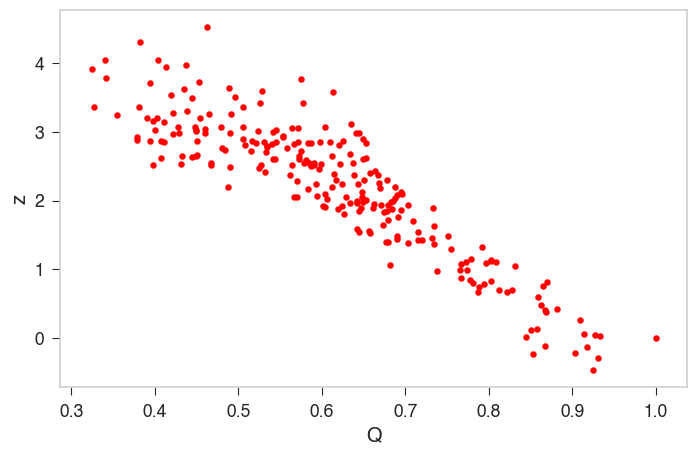

In [23]:
# Q_topology
d.plot.scatter("Q", "z", c="red")

In [54]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"

cutoff = 1.0
n_gamma = 10
gamma_list = np.linspace(1,10, num=n_gamma)
n_burial = 20
burial_list = np.linspace(1, 10, num=n_burial)
corr_array = np.zeros((n_gamma, n_burial))
n_idx = 10
for idx in range(n_idx):
    name = names[idx]
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    gamma = 2
    k_mem_burial = 1
    for i in range(n_gamma):
        for j in range(n_burial):
            gamma = gamma_list[i]
            k_mem_burial = burial_list[j]
            d = get_relative_k_data_rotation(gamma, decoy, decoyQ, native, include_mem_burial=4, k_mem_burial=k_mem_burial)
            corr, p = scipy.stats.pearsonr(d["Q_topology"], d["z"])
            corr_array[i][j] += corr
corr_array /= n_idx
# value_list, value_sum_list = get_value_array_3(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)


In [64]:
a = [1, 2, 3]

In [65]:
random.shuffle(a)

In [67]:
k_wat = 0.08473
k_mem = 0.29578
k_mem_burial = 0.28186

In [69]:
scale = 1/k_wat

In [70]:
k_mem_scaled = scale * k_mem
k_mem_burial_scaled = scale * k_mem_burial

In [71]:
k_mem_scaled

3.4908532987135605

In [72]:
k_mem_burial_scaled

3.326566741413903

In [73]:
pwd

'/Users/weilu/opt/notebook/Optimization'

In [131]:
pre = "/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane_wider_range/optimization"
os.chdir(pre)
# gamma_file_name = "gamma_iter1_combined_mar06.dat"
# gamma_file_name = "/Users/weilu/Research/server/sep_2019/peptide_optimization/saved_gammas/cutoff100"
gamma_file_name = f"{pre}/backup_gammas_complete_data/protein_list_phi_relative_k_with_membrane_wellrotation_gamma"
print(gamma_file_name)
data = validate_hamiltonian_wei("phi_list.txt", "random_100", gamma_file_name, "shifted", 240, mode=0, withBiased=True)
data
os.chdir('/Users/weilu/opt/notebook/Optimization')

/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane_wider_range/optimization/backup_gammas_complete_data/protein_list_phi_relative_k_with_membrane_wellrotation_gamma
0 2.837755578928542


In [132]:
data.head()

,Protein,Z_scores,E_native,E_mgs,Std_mg
0,3bo0,2.837756,-81.704938,-26.695350,19.384893
1,2jln,2.419395,-79.908959,-36.490407,17.946036
2,2zqp,3.387519,-56.411883,-22.079824,10.134868
3,6gct,3.867350,-196.706773,-98.342885,25.434439
4,4xu4,2.864312,-95.868761,-43.698031,18.214050


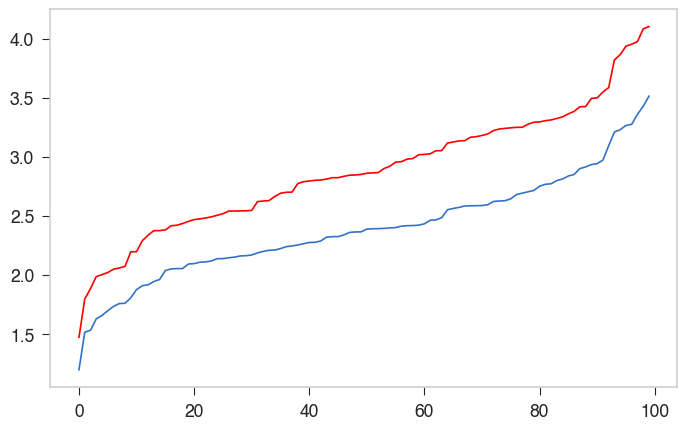

In [134]:
plt.plot(sorted(data["Z_scores"]), color="red")
plt.plot(sorted(data_no_weigted_by_bias["Z_scores"]))

In [130]:
data_no_weigted_by_bias = data

Text(0, 0.5, 'k_membrane_contact')

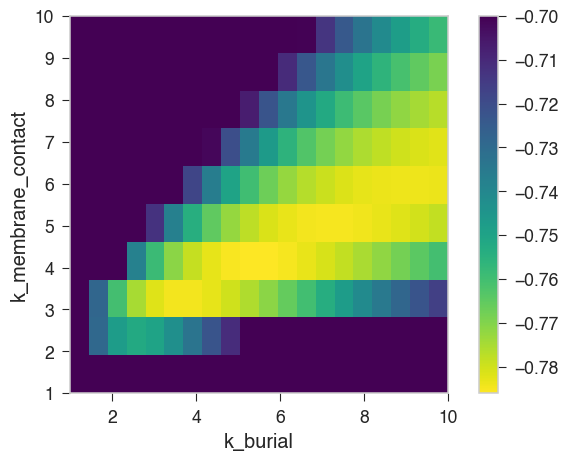

In [63]:
plt.imshow(corr_array, cmap="viridis_r", origin=0, extent=[1,10,1,10], vmax=-0.7)
plt.colorbar()
ax = plt.gca()
# ax.set_xticklabels(burial_list.round(1))
plt.xlabel("k_burial")
# ax.set_yticklabels(gamma_list)
plt.ylabel("k_membrane_contact")

Text(0, 0.5, 'k_membrane_contact')

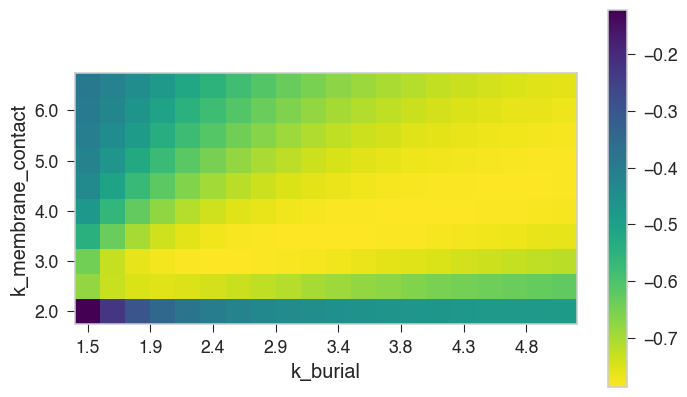

In [55]:
plt.imshow(corr_array, cmap="viridis_r", origin=0)
plt.colorbar()
ax = plt.gca()
ax.set_xticklabels(burial_list.round(1))
plt.xlabel("k_burial")
ax.set_yticklabels(gamma_list)
plt.ylabel("k_membrane_contact")

Text(0, 0.5, 'k_membrane_contact')

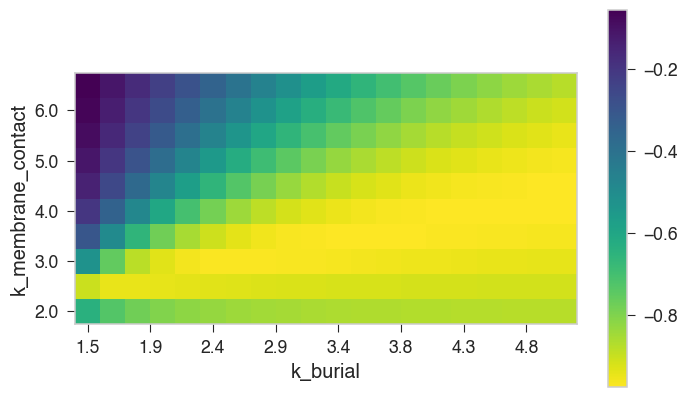

In [53]:
plt.imshow(corr_array, cmap="viridis_r", origin=0)
plt.colorbar()
ax = plt.gca()
ax.set_xticklabels(burial_list.round(1))
plt.xlabel("k_burial")
ax.set_yticklabels(gamma_list)
plt.ylabel("k_membrane_contact")

In [12]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
name = names[1]
cutoff = 1.0
gamma_list = np.linspace(1,15, num=100)
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
gamma = 2
d = get_relative_k_data_rotation(gamma, decoy, decoyQ, native, include_mem_burial=1)
# value_list, value_sum_list = get_value_array_3(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)


In [13]:
np.corrcoef(d[["Q", "z"]].values.T)

array([[ 1.        , -0.94678057],
       [-0.94678057,  1.        ]])

In [14]:
import scipy
corr, p = scipy.stats.pearsonr(d["Q"], d["z"])

In [15]:
corr

-0.9467805673348517

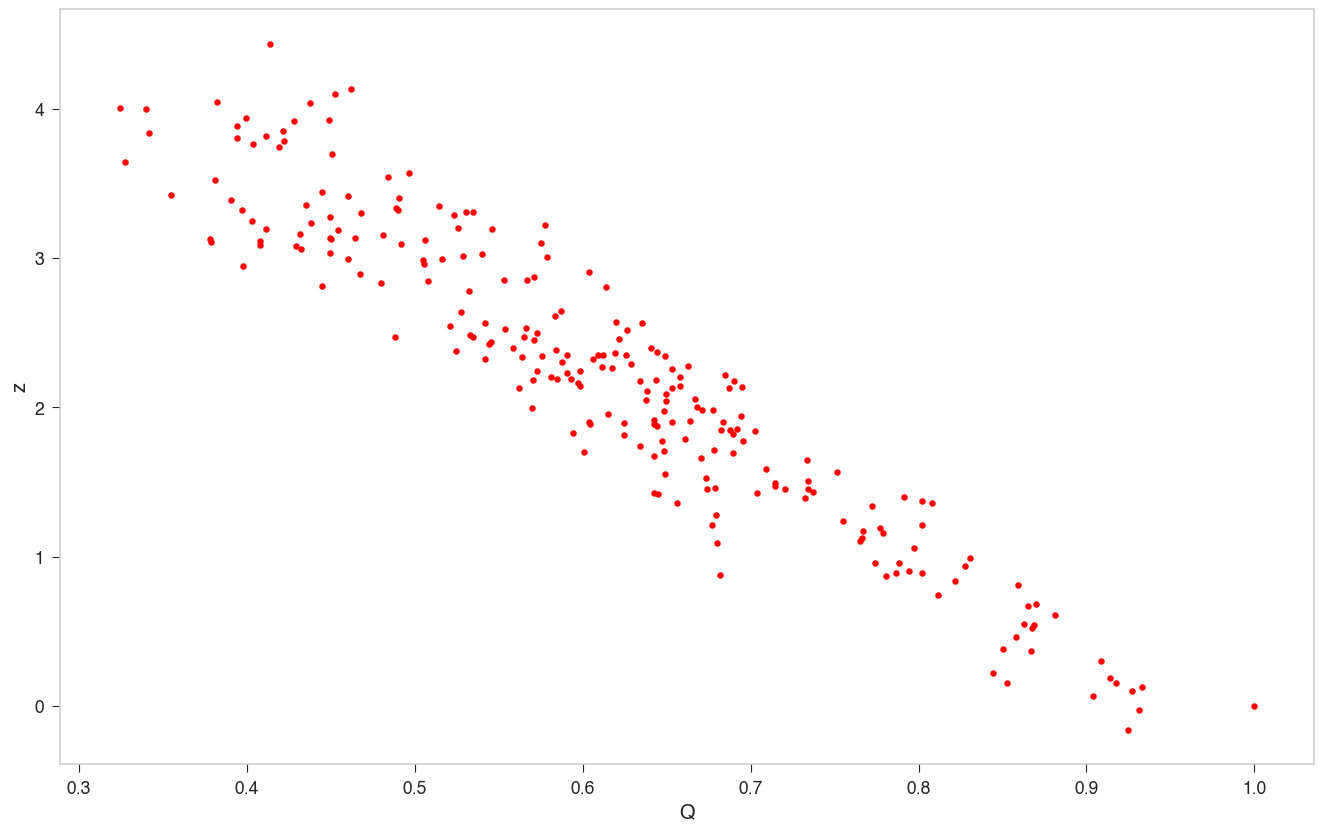

In [16]:
# Q_topology
d.plot.scatter("Q", "z", c="red")

In [ ]:
gamma_list = np.linspace(0,10, num=20)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
n = 10
for i, name in enumerate(names):
    cc += 1
    if i % 100 == n:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    one_value_list, one_value_sum_list = get_value_array_5(gamma_list, include_mem_burial=4, k_mem_burial=k_mem_burial, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/n
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average pearson correlation")

80


Text(0, 0.5, 'average pearson correlation')

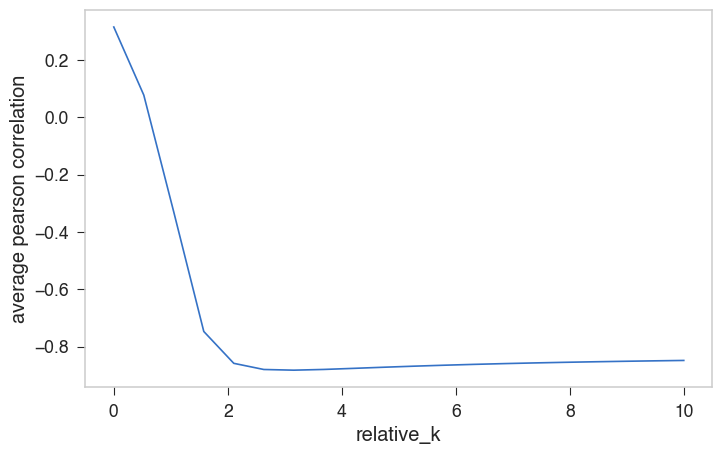

In [17]:
gamma_list = np.linspace(0,10, num=20)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
n = 80
for i, name in enumerate(names):
    cc += 1
    if i % 100 == n:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    one_value_list, one_value_sum_list = get_value_array_5(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff, include_mem_burial=1)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/n
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average pearson correlation")

80


Text(0, 0.5, 'average pearson correlation')

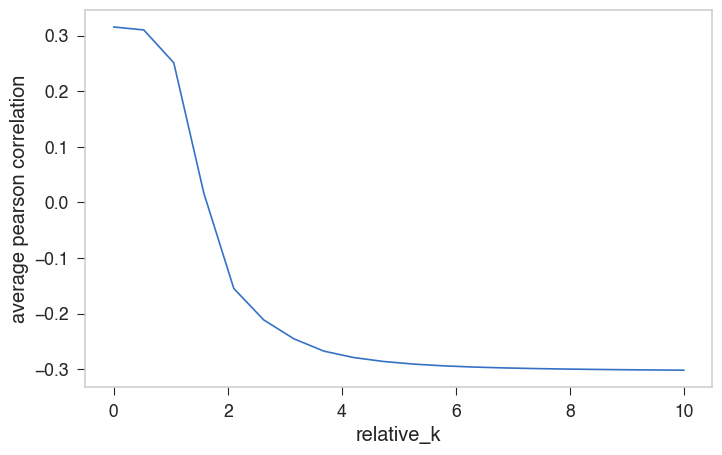

In [18]:
gamma_list = np.linspace(0,10, num=20)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
n = 80
for i, name in enumerate(names):
    cc += 1
    if i % 100 == n:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    one_value_list, one_value_sum_list = get_value_array_5(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff, include_mem_burial=0)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/n
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average pearson correlation")

80


Text(0, 0.5, 'average pearson correlation')

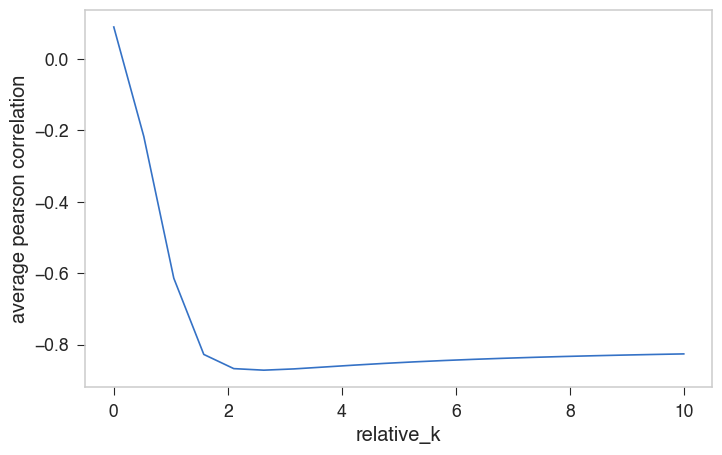

In [142]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_with_burial_and_membrane"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/phis"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/back_phis/"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(0,10, num=20)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
n = 80
for i, name in enumerate(names):
    cc += 1
    if i % 100 == n:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    one_value_list, one_value_sum_list = get_value_array_5(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff, include_mem_burial=1)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/n
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average pearson correlation")

In [ ]:
# 4p6v is big.

Text(0, 0.5, 'average fraction of decoys that E_decoy > E_native')

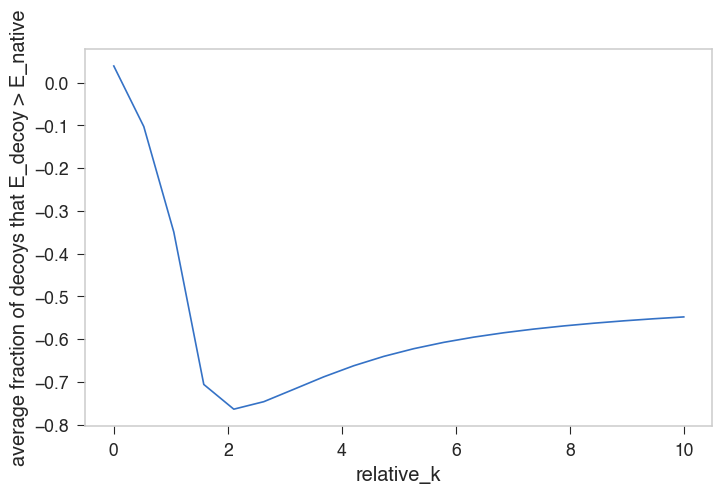

In [139]:
# 1 to 0.5, mode 3
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
# plt.ylim((-1, 1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

Text(0, 0.5, 'average fraction of decoys that E_decoy > E_native')

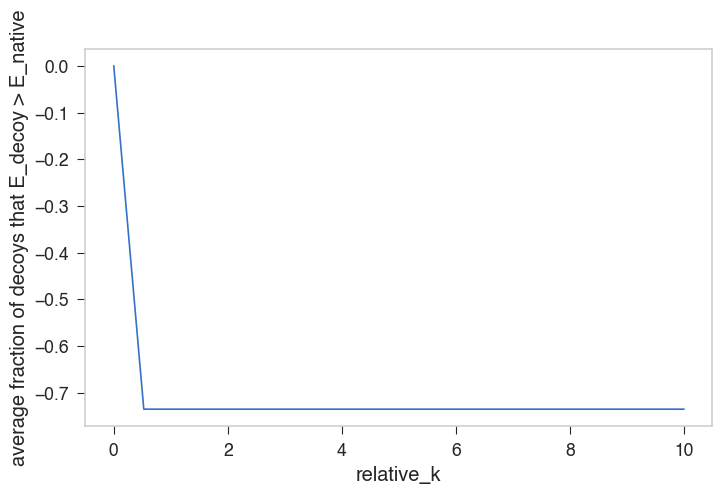

In [131]:
# membrane only
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
# plt.ylim((-1, 1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

Text(0, 0.5, 'average fraction of decoys that E_decoy > E_native')

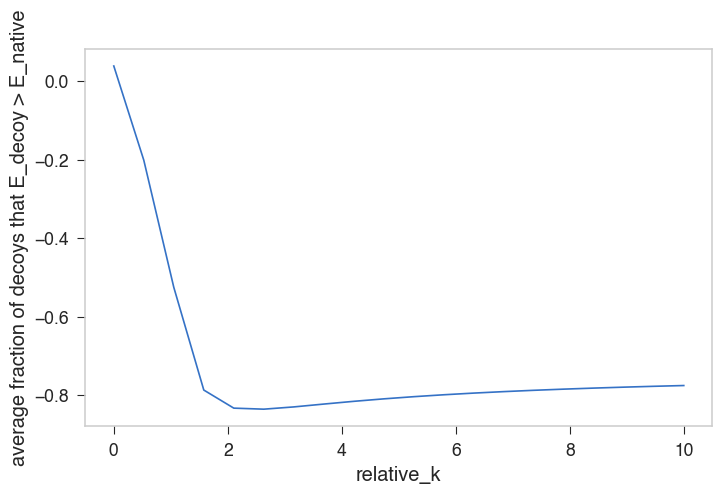

In [129]:
# together mode 1 
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
# plt.ylim((-1, 1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

In [119]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_with_burial_and_membrane"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/phis"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/back_phis/"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(0,10, num=20)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
for i, name in enumerate(names):
    cc += 1
    if i % 100 == 40:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_rotation")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_rotation")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_rotation")
    one_value_list, one_value_sum_list = get_value_array_5(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

40


Text(0, 0.5, 'average fraction of decoys that E_decoy > E_native')

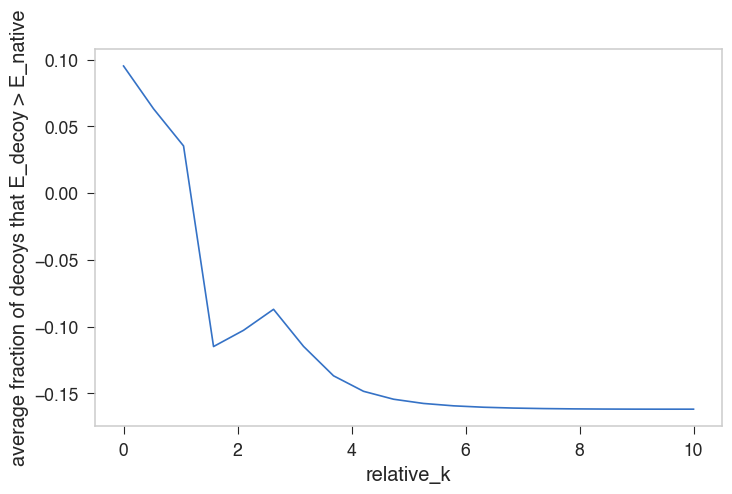

In [120]:

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
# plt.ylim((-1, 1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

Text(0, 0.5, 'average fraction of decoys that E_decoy > E_native')

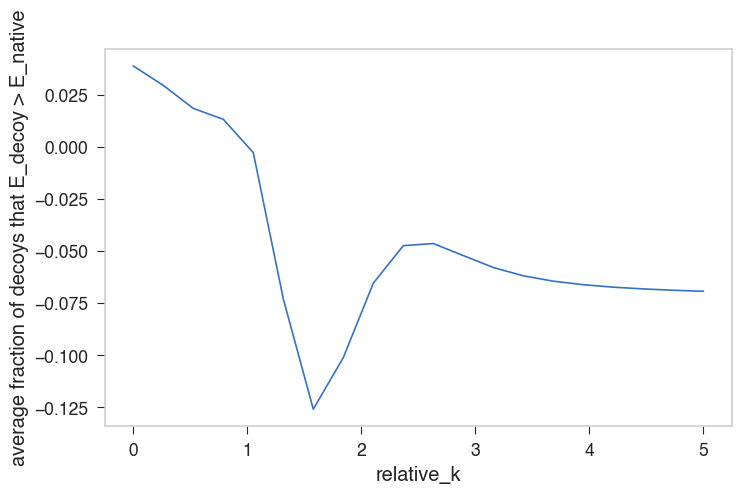

In [116]:

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
# plt.ylim((-1, 1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)